In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import numpy as np
import pandas as pd
import os
from PIL import Image
import torch
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, PNDMScheduler
from tqdm import tqdm 
import requests
from io import BytesIO
from torchvision import transforms

2025-04-15 12:40:57.872863: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744720858.053086      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744720858.106002      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
vae = AutoencoderKL.from_pretrained("stable-diffusion-v1-5/stable-diffusion-v1-5", subfolder = "vae")

tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")

unet = UNet2DConditionModel.from_pretrained("stable-diffusion-v1-5/stable-diffusion-v1-5", subfolder = "unet")
scheduler = PNDMScheduler.from_pretrained("stable-diffusion-v1-5/stable-diffusion-v1-5", subfolder = "scheduler")

config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.52k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

In [4]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Using device: ", device)

Using device:  cuda


In [5]:
shape = (512, 512)
seed = 42

In [51]:
def generate(vae, tokenizer, text_encoder, unet, scheduler, seed, 
             device, prompt, negative_prompt, shape, cfg_scale, 
             num_inference_steps, batch_size, input_images = None, strength = None):
    with torch.no_grad():
        if strength is not None:
            if not (0 <= strength and 1>= strength):
                raise ValueError("Strength must be between 0 and 1")
        generator = torch.Generator(device=device).manual_seed(seed)
        idle_device = torch.device("cpu")
        text_encoder.to(device)
        cond_tokens = tokenizer.batch_encode_plus([prompt] * batch_size, max_length=tokenizer.model_max_length, padding="max_length", return_tensors="pt", truncation = True).input_ids.to(device)
        uncond_tokens = tokenizer.batch_encode_plus([negative_prompt] * batch_size, max_length=tokenizer.model_max_length, padding="max_length", return_tensors="pt", truncation = True).input_ids.to(device)
        cond_embedding = text_encoder(cond_tokens)[0]
        uncond_embedding = text_encoder(uncond_tokens)[0]
        text_encoder.to(idle_device)
        context = torch.cat([uncond_embedding, cond_embedding])
        width, height = shape
        t_start = 0
        scheduler.set_timesteps(num_inference_steps, device=device)
        vae.to(device)
        if input_images is None:
            latents = torch.randn((batch_size, 4, width // 8, height // 8), generator=generator, device=device)
            latents = latents * scheduler.init_noise_sigma
        else:
            init_latents = vae.encode(input_images.to(device)).latent_dist.sample()
            init_latents = init_latents * 0.18215
            init_latents = torch.cat([init_latents] * batch_size)
            init_timestep = int(num_inference_steps * strength)
            time_steps = scheduler.timesteps[-init_timestep]
            time_steps = torch.tensor([time_steps] * batch_size, device=device, dtype= torch.long)
            noise = torch.randn(init_latents.shape, generator=generator, device=device)
            init_latents = scheduler.add_noise(init_latents, noise, time_steps)
            latents = init_latents
            t_start = max(0, num_inference_steps - init_timestep)
        unet.to(device)
        for t in tqdm((scheduler.timesteps[t_start:])):
            latents_model_input = torch.cat([latents] * 2)
            latents_model_input = scheduler.scale_model_input(latents_model_input, t)
            model_output = unet(latents_model_input, t, encoder_hidden_states=context).sample
            output_uncond, output_cond = model_output.chunk(2)
            noise_pred = output_uncond + cfg_scale * (output_cond - output_uncond)
            latents = scheduler.step(noise_pred, t, latents).prev_sample
        latents = 1 / 0.18215 * latents
        unet.to(idle_device)
        images = vae.decode(latents).sample
        vae.to(idle_device)
        images = (images / 2 + 0.5).clamp(0, 1)
        images = images.cpu().permute(0, 2, 3, 1).numpy()
        images = (images * 255).round().astype("uint8")
        return images

# Text to Image

In [36]:
prompt = "A dog with sunglasses, wearing helmet, stretching on the seaside, high detailed"
negative_prompt = ""
cfg_scale = 8
num_inference_steps = 50
batch_size = 2
image = generate(vae = vae, tokenizer = tokenizer, text_encoder = text_encoder, unet = unet, 
                scheduler = scheduler, batch_size = batch_size, seed = seed, device = device, prompt = prompt, negative_prompt = negative_prompt,
                shape = shape, cfg_scale = cfg_scale, num_inference_steps = num_inference_steps)
# image (batch_size, width, hegith, 3) contain batch_size images

100%|██████████| 51/51 [00:23<00:00,  2.15it/s]


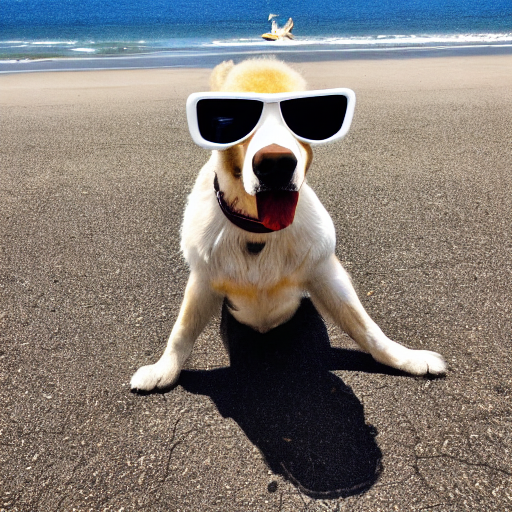

In [37]:
Image.fromarray(image[1])

# Image to Image

In [ ]:
url = "https://cats.com/wp-content/uploads/2024/07/Beautiful-red-cat-stretches-and-shows-tongue.jpg" # replace this url with your own
response = requests.get(url)
input_image = Image.open(BytesIO(response.content)).convert("RGB")
transform = transforms.Compose([
    transforms.Resize(shape),          # Resize đúng kích thước (tuỳ mô hình)
    transforms.ToTensor(),                  # [0, 255] → [0, 1]
    transforms.Normalize([0.5]*3, [0.5]*3)   # [0, 1] → [-1, 1] cho 3 channel RGB
])
input_image = transform(input_image).unsqueeze(0)
prompt = "A cat with sunglasses, wearing comfy hat, looking at camera, highly detailed, ultra sharp, cinematic, 100mm lens, 8k resolution."
negative_prompt = ""
cfg_scale = 8
num_inference_steps = 50
batch_size = 2
strength = 0.8
image = generate(vae = vae, tokenizer = tokenizer, text_encoder = text_encoder, unet = unet, 
                scheduler = scheduler, batch_size = batch_size, seed = seed, device = device, prompt = prompt, negative_prompt = negative_prompt,
                shape = shape, cfg_scale = cfg_scale, num_inference_steps = num_inference_steps, input_images = input_image, strength = strength)

100%|██████████| 41/41 [00:19<00:00,  2.15it/s]


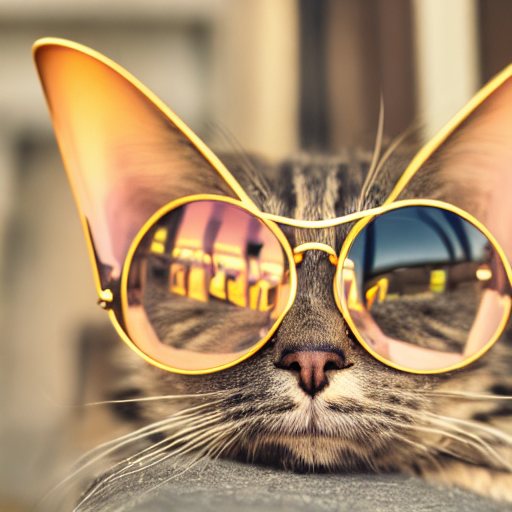

In [58]:
Image.fromarray(image[1])